## Libraries

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import bt
import matplotlib.pyplot as plt
from datetime import date

%matplotlib inline

## Functions

In [2]:
def consulta_bc(codigo_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'],dayfirst=True)
    df.set_index('data',inplace=True)
    return df 

In [10]:
def cdi_acumulado (initial_date, end_date):
    cdi = consulta_bc(12)
    cdi_acumulado = (1 + cdi[initial_date : end_date] / 100).cumprod()
    cdi_acumulado.iloc[0] = 1
    return cdi_acumulado

## Load data

In [121]:
initial_date = '2003-12-01'
end_date = date.today().strftime('%Y-%m-%d')

In [122]:
tickers_portfolio = ['^BVSP', '^GSPC','USDBRL=X']

In [125]:
stock_data = yf.download (tickers_portfolio,start=initial_date,end=end_date)["Close"]
stock_data["cdi"] = cdi_acumulado (initial_date,end_date)
stock_data.head()

[*********************100%***********************]  3 of 3 completed


,USDBRL=X,^BVSP,^GSPC,cdi
Date,,,,
2003-12-01,2.923,20521.0,1070.119995,1.000000
2003-12-02,2.931,20458.0,1066.619995,1.001262
2003-12-03,2.931,20540.0,1064.729980,1.001893
2003-12-04,2.943,20414.0,1069.719971,1.002525
2003-12-05,2.934,20880.0,1061.500000,1.003157


In [126]:
#Create theoretical stocks that follow the indices
stock_data.dropna(inplace=True)
stock_data["^GSPC_br"] = stock_data["^GSPC"] * stock_data["USDBRL=X"]
stock_data["BVSP_index"] = np.nan
stock_data["GSPC_index"] = np.nan
stock_data["GSPC_br_index"] = np.nan
stock_data["cdi_index"] = np.nan

for i in range (stock_data.shape[0]):
    if i == 0:
        stock_data["BVSP_index"][i] =  100
        stock_data["GSPC_index"][i] = 100 
        stock_data["GSPC_br_index"][i] = 100
        stock_data["cdi_index"][i] = stock_data["cdi"][i] * 100
    else:
        Growth_BVSP = (stock_data["^BVSP"][i]/stock_data["^BVSP"][i-1]) - 1
        Growth_GSPC = (stock_data["^GSPC"][i]/stock_data["^GSPC"][i-1]) - 1
        Growth_GSPC_br = (stock_data["^GSPC_br"][i]/stock_data["^GSPC_br"][i-1]) - 1

        stock_data["BVSP_index"][i] = (stock_data["BVSP_index"][i-1] * Growth_BVSP) + stock_data["BVSP_index"][i-1]
        stock_data["GSPC_index"][i] = (stock_data["GSPC_index"][i-1] * Growth_GSPC) + stock_data["GSPC_index"][i-1]
        stock_data["GSPC_br_index"][i] = (stock_data["GSPC_br_index"][i-1] * Growth_GSPC_br) + stock_data["GSPC_br_index"][i-1]
        stock_data["cdi_index"][i] = stock_data["cdi"][i] * 100

In [127]:
stock_data.tail()

,USDBRL=X,^BVSP,^GSPC,cdi,^GSPC_br,BVSP_index,GSPC_index,GSPC_br_index,cdi_index
Date,,,,,,,,,
2021-05-26,5.3307,123989.0,4195.990234,5.871953,22367.564809,604.205448,392.104647,715.084551,587.195291
2021-05-27,5.3105,124367.0,4200.879883,5.872732,22308.773227,606.047464,392.561573,713.205002,587.273206
2021-05-28,5.2382,125561.0,4204.109863,5.873511,22021.969075,611.865893,392.863406,704.035956,587.351132
2021-06-01,5.2166,128267.0,4202.040039,5.875070,21920.361821,625.052385,392.669986,700.787602,587.507013
2021-06-02,5.1497,129601.0,4208.120117,5.875850,21670.556861,631.553043,393.238154,692.801410,587.584970


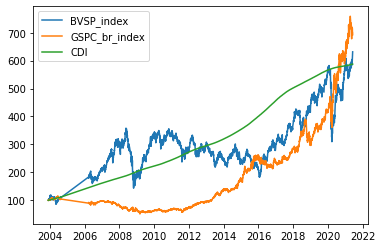

In [128]:
plt.plot (stock_data["BVSP_index"],label="BVSP_index")
plt.plot (stock_data["GSPC_br_index"], label="GSPC_br_index")
plt.plot (stock_data["cdi_index"], label="CDI")
plt.legend();

## Backtesting

In [129]:
arca = bt.Strategy ('arca', [bt.algos.RunMonthly (run_on_end_of_period=True),
    bt.algos.SelectAll(), 
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()])
full_bvsp = bt.Strategy ('full_bvsp', [bt.algos.RunOnce (),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()])
full_gspc = bt.Strategy ('full_gspc', [bt.algos.RunOnce (),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()])
full_cdi = bt.Strategy ('full_cdi', [bt.algos.RunOnce (),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()])

In [111]:
bt1 = bt.Backtest(arca, stock_data[["BVSP_index","GSPC_br_index","cdi"]])
bt2 = bt.Backtest(full_bvsp, stock_data[["^BVSP"]])
bt3 = bt.Backtest(full_gspc, stock_data[["^GSPC_br"]])
bt4 = bt.Backtest(full_cdi, stock_data[["cdi"]])

In [130]:
results = bt.run (bt1,bt2,bt3,bt4)

C:\Program Files\Python39\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
C:\Program Files\Python39\lib\site-packages\ffn\core.py:258: RuntimeWarning: divide by zero encountered in true_divide
  self.calmar = np.divide(self.cagr, np.abs(self.max_drawdown))
C:\Program Files\Python39\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
C:\Program Files\Python39\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


## Results

In [131]:
results.display()

Stat                 arca        full_bvsp    full_gspc    full_cdi
-------------------  ----------  -----------  -----------  ----------
Start                2003-11-30  2003-11-30   2003-11-30   2003-11-30
End                  2021-06-02  2021-06-02   2021-06-02   2021-06-02
Risk-free rate       0.00%       0.00%        0.00%        0.00%

Total Return         668.66%     523.58%      591.51%      487.58%
Daily Sharpe         0.90        0.52         0.62         1.55
Daily Sortino        1.62        0.97         1.03         inf
CAGR                 12.36%      11.02%       11.68%       10.65%
Max Drawdown         -27.91%     -59.71%      -55.05%      0.00%
Calmar Ratio         0.44        0.18         0.21         inf

MTD                  0.55%       3.21%        -1.60%       0.04%
3m                   5.25%       16.15%       -0.74%       0.69%
6m                   10.34%      15.86%       13.47%       1.14%
YTD                  7.21%       8.61%        11.48%       1.00%
1Y     

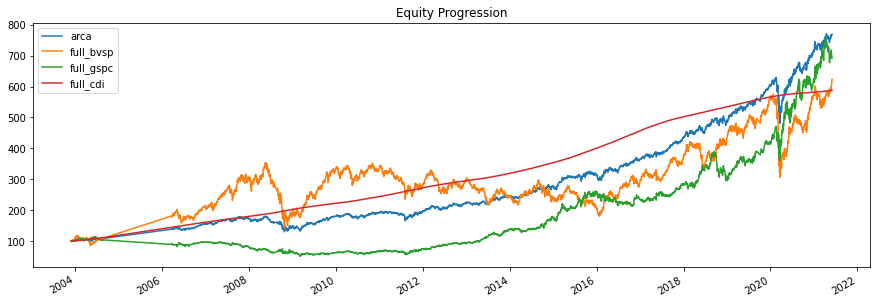

In [132]:
results.plot();

In [110]:
results.get_transactions()

price  quantity
Date       Security                         
2003-12-01 ^BVSP      20521.000000      16.0
           ^GSPC_br    3127.960850     106.0
           cdi            1.000000  333333.0
2003-12-30 ^BVSP      22236.000000      -1.0
           ^GSPC_br    3219.065708       1.0
...                            ...       ...
2021-04-30 ^BVSP     118894.000000      -1.0
           ^GSPC_br   22312.395305       3.0
           cdi            5.858454   -1685.0
2021-05-28 ^GSPC_br   22021.969075       3.0
           cdi            5.873511    5010.0

[474 rows x 2 columns]